<h2>INSTALLAZIONE LIBRERIE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Installazione librerie <strong>necessarie per il funzionamento</strong> del progetto:
</p>

In [1]:
pip install --quiet --upgrade pip scipy matplotlib wordcloud seaborn nltk scikit-learn plotly nbformat imbalanced-learn tqdm xgboost pillow tabulate

Note: you may need to restart the kernel to use updated packages.


<h2>IMPORTAZIONE LIBRERIE</h2>

In [2]:
# Calcolo e manipolazione dati
import numpy as np
import pandas as pd
from collections import Counter
import re
import string
import warnings

# NLP e Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Gestione degli squilibri di classe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning e Modelli
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metriche di valutazione
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, log_loss,
                             precision_recall_fscore_support, classification_report, 
                             accuracy_score, f1_score, precision_score, recall_score)
from tabulate import tabulate

# Utility
from sklearn.utils import resample
from tqdm import tqdm  # Barra di avanzamento
import time
import matplotlib.image as mpimg
from IPython.display import Image, display
from IPython.core.display import HTML
from sklearn.exceptions import ConvergenceWarning

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

# Ignorare avvisi
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", ConvergenceWarning)


<h2> BACKGROUND </h2>

<p>Il set di dati <strong>MSKCC</strong> è composto da set di dati di addestramento e di test di mutazioni genetiche insieme a <strong>prove cliniche testuali</strong>. Gli <strong>esperti clinici</strong> hanno annotato manualmente le mutazioni genetiche fornite nel set di addestramento e le hanno classificate in <strong>nove diverse classi</strong> dopo aver interpretato le prove cliniche testuali.</p>

<p>Le <strong>nove diverse classi</strong> di mutazioni genetiche sono le seguenti:</p>


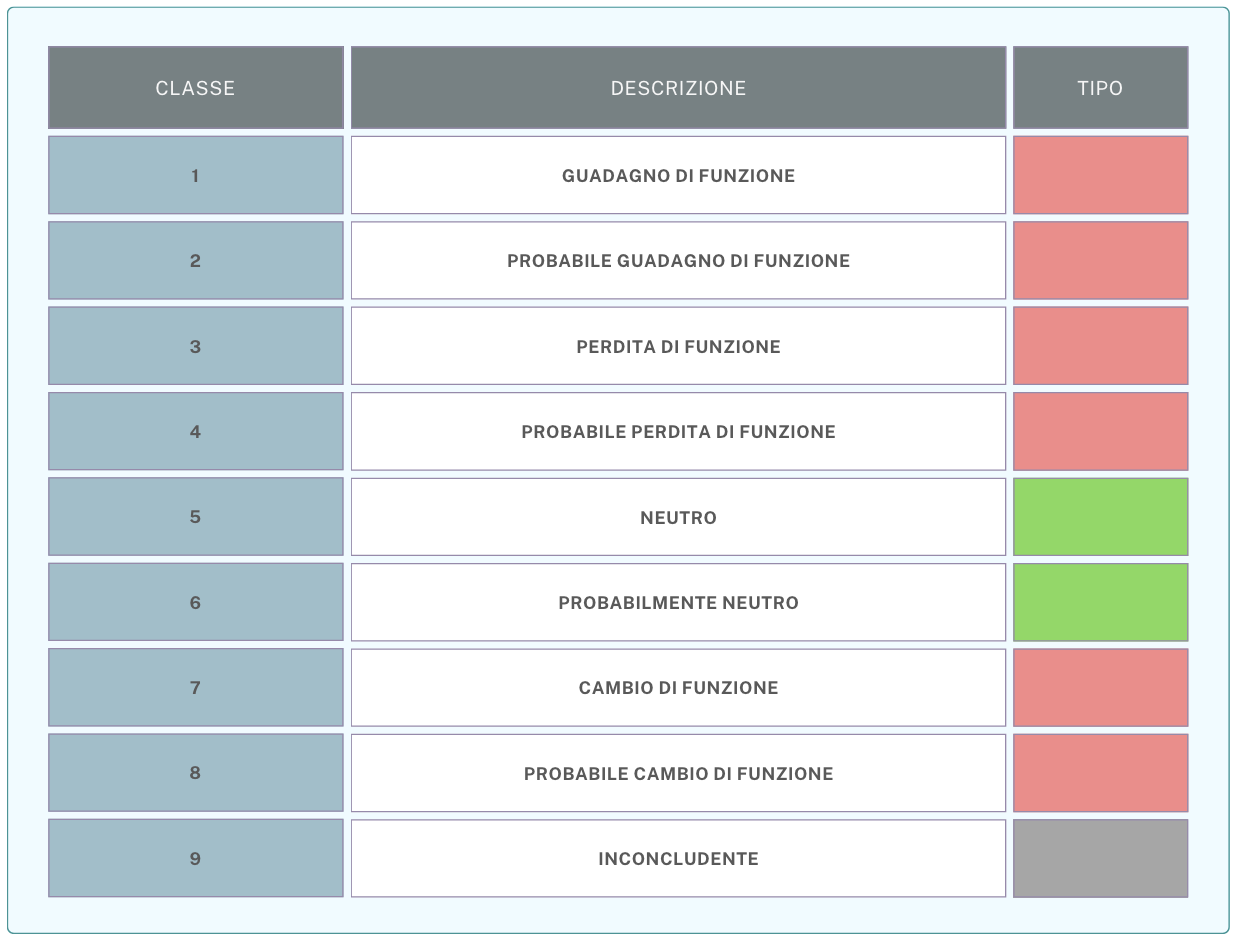

In [3]:
# Percorso dell'immagine
img_path = "/Users/diego/Desktop/TIROCINIO/DATASET/3.png"

# Mostra l'immagine ridimensionata
display(Image(filename=img_path, width=700, height=700))  # Specifica larghezza e altezza in pixel

<h2>ESPLORAZIONE DEI DATI (EDA)</h2>

In [4]:
# Caricamento Dataset
training_variants = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_variants.csv")
training_text = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_text.csv", sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','text'])

# Stampa strutturata dei dati
print(f"{'\nDataset':<20}{'(Righe, Colonne)':<30}")
print(f"{'-'*50}")
print(f"{'Training variants':<20}{str(training_variants.shape):<30}")
print(f"{'Training text':<20}{str(training_text.shape):<30}")



Dataset            (Righe, Colonne)              
--------------------------------------------------
Training variants   (3321, 4)                     
Training text       (3321, 2)                     


In [5]:
#unione varianti e testo di addestramento 
df = pd.merge(training_variants, training_text, on = 'ID')
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


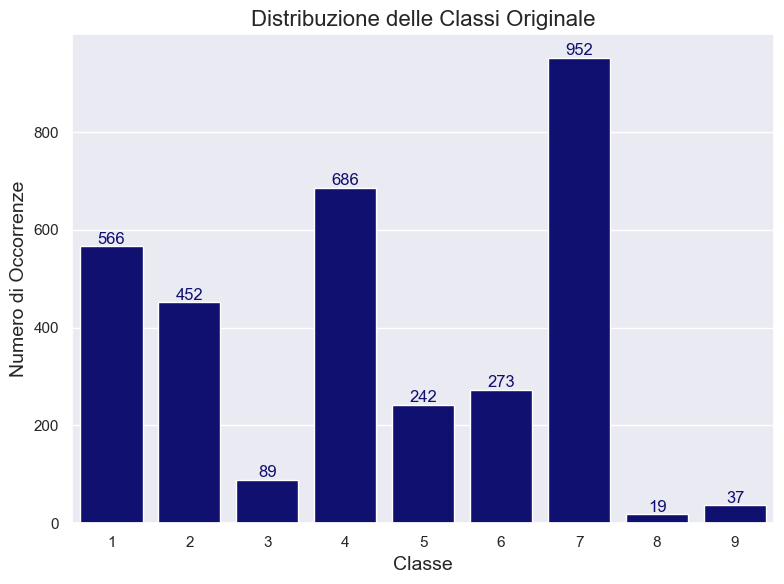

In [21]:
# Impostazioni estetiche per il grafico
sns.set(style="darkgrid")  # Aggiunge uno sfondo gradevole

# Creazione del grafico
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Class', data=df, color='navy')  # Imposta un colore uniforme per le barre

# Titolo e etichette
plt.title('Distribuzione delle Classi Originale', fontsize=16)
plt.xlabel('Classe', fontsize=14)
plt.ylabel('Numero di Occorrenze', fontsize=14)

# Aggiungere il numero sopra ogni barra con lo stesso colore della barra
for p in ax.patches:
    height = int(p.get_height())  # Otteniamo l'altezza della barra
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, 
                color=p.get_facecolor(),  # Impostiamo il colore del testo uguale a quello della barra
                xytext=(0, 5), textcoords='offset points')

# Mostra il grafico
plt.tight_layout()  # Ottimizza la disposizione per evitare sovrapposizioni
plt.show()


<h2>PRE-ELABORAZIONE DEL TESTO</h2>

In [7]:
# Inserimento di altre stop words manualmente adatte al contesto
custom_words = ["fig", "figure", "et", "al", "al.", "also", "data", "analyze", "study", 
                "table", "using", "method", "result", "conclusion", "author", "find", "found", "show"]

# Unione delle stop words di default + la punteggiatura + quelle aggiunte manualmente 
stop_words = set(stopwords.words('english') + list(string.punctuation) + custom_words)

wordnet_lemmatizer = WordNetLemmatizer()

def pre_process(text):
    if isinstance(text, float):
        return ''  # Gestione di valori float
    
    text = str(text).lower().strip()
    
    # Rimozione di punteggiatura, HTML e caratteri speciali
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'<.*?>+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenizzazione, rimozione stopwords e lemmatizzazione
    tokens = word_tokenize(text)
    filtered_tokens = [
        wordnet_lemmatizer.lemmatize(word) for word in tokens 
        if word not in stop_words and not word.isdigit() and len(word) > 1  # ignora parole di lunghezza 1
    ]
    
    return ' '.join(filtered_tokens)



def process_corpus(df, text_column, class_column):
    return df.groupby(class_column).apply(lambda x: Counter(word_tokenize(pre_process(x[text_column].str.cat(sep=' ')))))


In [8]:
# Preprocessing dei dati con barra di avanzamento
print("Preprocessing dei dati...")
df['text'] = [pre_process(text) for text in tqdm(df['text'], desc="Preprocessing")]

Preprocessing dei dati...


Preprocessing: 100%|████████████████████████| 3321/3321 [01:38<00:00, 33.59it/s]


In [9]:
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutation monomeric casitas lineage l...


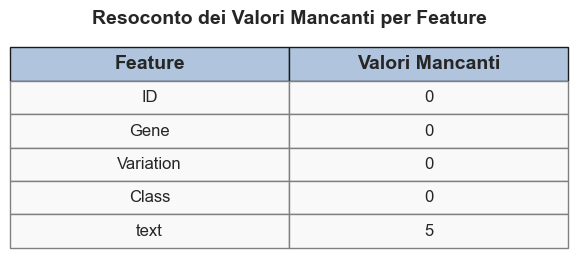

In [10]:
# Calcola i valori mancanti (nulli o vuoti)
null_counts = df.isnull().sum()
empty_counts = (df == "").sum()
total_missing = null_counts + empty_counts

# Crea una tabella riepilogativa con solo due colonne
missing_summary = pd.DataFrame({
    "Feature": df.columns,
    "Valori Mancanti": total_missing
}).reset_index(drop=True)

# Crea una tabella visiva con matplotlib
fig, ax = plt.subplots(figsize=(6, 3))  # Imposta la dimensione della tabella
ax.axis('tight')  # Disabilita gli assi
ax.axis('off')    # Disabilita gli assi

# Usa pandas per creare la tabella visiva
table = ax.table(cellText=missing_summary.values, colLabels=missing_summary.columns, loc='center', cellLoc='center')

# Personalizzazione estetica
table.auto_set_font_size(False)
table.set_fontsize(12)  # Imposta la dimensione del font
table.scale(1.2, 2)      # Aumenta la scala delle righe (modifica il secondo parametro per cambiare l'altezza delle righe)

# Modifica i bordi delle celle
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Modifica la prima riga (intestazione)
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#B0C4DE')  # Colore di sfondo per l'intestazione
    else:
        cell.set_edgecolor('gray')  # Colore dei bordi
        cell.set_facecolor('#f9f9f9')  # Colore di sfondo delle celle

# Aggiungi il titolo
plt.title("Resoconto dei Valori Mancanti per Feature", fontsize=14, weight='bold')

# Mostra la tabella
plt.show()


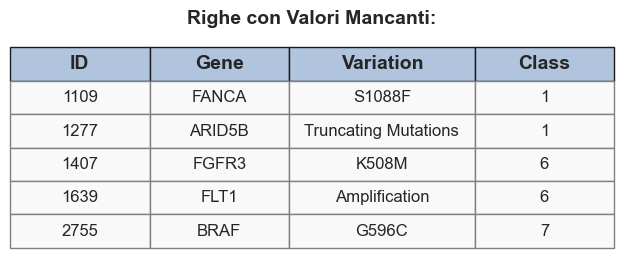

In [16]:
# Seleziona le righe con valori mancanti (nulli o vuoti)
rows_with_missing = df[df.isnull().any(axis=1) | (df == "").any(axis=1)]

# Seleziona solo le colonne "ID", "Gene", "Variation" e "Class"
subset_df = rows_with_missing[["ID", "Gene", "Variation", "Class"]].head(5)

# Crea una tabella visiva con matplotlib
fig, ax = plt.subplots(figsize=(6, 3))  # Imposta la dimensione della tabella
ax.axis('tight')  # Disabilita gli assi
ax.axis('off')    # Disabilita gli assi

# Usa pandas per creare la tabella visiva
table = ax.table(cellText=subset_df.values, colLabels=subset_df.columns, loc='center', cellLoc='center')

# Personalizzazione estetica
table.auto_set_font_size(False)
table.set_fontsize(12)  # Imposta la dimensione del font
table.scale(1.2, 2)      # Aumenta la scala delle righe (modifica il secondo parametro per cambiare l'altezza delle righe)

# Modifica i bordi delle celle
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Modifica la prima riga (intestazione)
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#B0C4DE')  # Colore di sfondo per l'intestazione
    else:
        cell.set_edgecolor('gray')  # Colore dei bordi
        cell.set_facecolor('#f9f9f9')  # Colore di sfondo delle celle

# Imposta la larghezza della colonna "Variation"
table.auto_set_column_width(col=2)  # col=2 corrisponde alla colonna "Variation"

# Aggiungi il titolo
plt.title("Righe con Valori Mancanti:", fontsize=14, weight='bold')

# Mostra la tabella
plt.show()

In [17]:
# Elimina righe con valori nulli o con campo 'text' vuoto
df = df.dropna(subset=["text"]).loc[df['text'] != '']

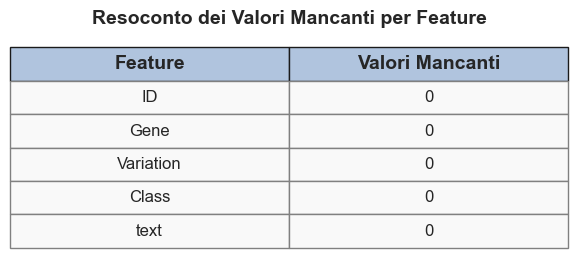

In [18]:
# Calcola i valori mancanti (nulli o vuoti)
null_counts = df.isnull().sum()
empty_counts = (df == "").sum()
total_missing = null_counts + empty_counts

# Crea una tabella riepilogativa con solo due colonne
missing_summary = pd.DataFrame({
    "Feature": df.columns,
    "Valori Mancanti": total_missing
}).reset_index(drop=True)

# Crea una tabella visiva con matplotlib
fig, ax = plt.subplots(figsize=(6, 3))  # Imposta la dimensione della tabella
ax.axis('tight')  # Disabilita gli assi
ax.axis('off')    # Disabilita gli assi

# Usa pandas per creare la tabella visiva
table = ax.table(cellText=missing_summary.values, colLabels=missing_summary.columns, loc='center', cellLoc='center')

# Personalizzazione estetica
table.auto_set_font_size(False)
table.set_fontsize(12)  # Imposta la dimensione del font
table.scale(1.2, 2)      # Aumenta la scala delle righe (modifica il secondo parametro per cambiare l'altezza delle righe)

# Modifica i bordi delle celle
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Modifica la prima riga (intestazione)
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#B0C4DE')  # Colore di sfondo per l'intestazione
    else:
        cell.set_edgecolor('gray')  # Colore dei bordi
        cell.set_facecolor('#f9f9f9')  # Colore di sfondo delle celle

# Aggiungi il titolo
plt.title("Resoconto dei Valori Mancanti per Feature", fontsize=14, weight='bold')

# Mostra la tabella
plt.show()


In [19]:
df.shape

(3316, 5)

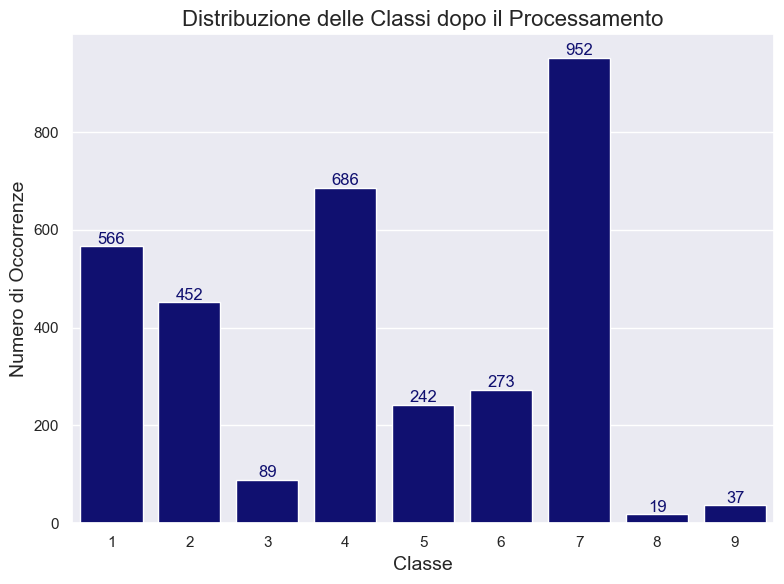

In [20]:
# Impostazioni estetiche per il grafico
sns.set(style="darkgrid")  # Aggiunge uno sfondo gradevole

# Creazione del grafico
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Class', data=df, color='navy')  # Imposta un colore uniforme per le barre

# Titolo e etichette
plt.title('Distribuzione delle Classi dopo il Processamento', fontsize=16)
plt.xlabel('Classe', fontsize=14)
plt.ylabel('Numero di Occorrenze', fontsize=14)

# Aggiungere il numero sopra ogni barra con lo stesso colore della barra
for p in ax.patches:
    height = int(p.get_height())  # Otteniamo l'altezza della barra
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, 
                color=p.get_facecolor(),  # Impostiamo il colore del testo uguale a quello della barra
                xytext=(0, 5), textcoords='offset points')

# Mostra il grafico
plt.tight_layout()  # Ottimizza la disposizione per evitare sovrapposizioni
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Impostazioni estetiche per il grafico
sns.set(style="darkgrid")  # Aggiunge uno sfondo gradevole

# Ordinare i dati in ordine decrescente
df_sorted = df.groupby('Class').size().reset_index(name='counts').sort_values(by='counts', ascending=False)

# Creazione del grafico
plt.figure(figsize=(8, 6))

# Aggiungere il parametro `order` per ordinare le barre in ordine decrescente
ax = sns.barplot(x='Class', y='counts', data=df_sorted, color='navy', order=df_sorted['Class'])  # Ordinamento delle classi

# Calcolare le percentuali
total = df_sorted['counts'].sum()
percentages = df_sorted['counts'].apply(lambda x: f'{x / total * 100:.1f}%')

# Aggiungere le percentuali sopra ogni barra e farle dello stesso colore delle barre
for i, p in enumerate(ax.patches):
    height = p.get_height()
    color = p.get_facecolor()  # Ottieni il colore della barra
    ax.annotate(f'{percentages.iloc[i]}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=12, 
                color=color,  # Usa lo stesso colore della barra per il testo
                xytext=(0, 5), textcoords='offset points')

# Titolo e etichette
plt.title('Distribuzione delle Classi in Percentuale', fontsize=16)
plt.xlabel('Classe', fontsize=14)
plt.ylabel('Numero di Occorrenze', fontsize=14)

# Mostra il grafico
plt.tight_layout()  # Ottimizza la disposizione per evitare sovrapposizioni
plt.show()


<h2> ANALISI DELLE FEATURE: </h2>

<h3> - GENI </h3>

In [ ]:
print("Numero di geni unici:", df['Gene'].nunique())

In [ ]:
gene_counts = df['Gene'].value_counts()  # Conta le occorrenze di ogni gene
# Impostazioni estetiche per il grafico
sns.set(style="darkgrid")  # Aggiunge uno sfondo gradevole

# Creazione del grafico
plt.figure(figsize=(10, 6))  # Grafico più piccolo
ax = sns.barplot(x=gene_counts.head(10).index, y=gene_counts.head(10).values, color='navy')

# Aggiungere il numero intero di occorrenze sopra ogni barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Numero intero sopra la barra
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, 
                color='navy',  # Colore del testo uguale al colore delle barre
                xytext=(0, 5), textcoords='offset points')

# Titolo e etichette
plt.title('Top 10 Geni più frequenti', fontsize=16)
plt.xlabel('Gene', fontsize=14)
plt.ylabel('Frequenza', fontsize=14)

# Ruotare le etichette sull'asse X per una migliore leggibilità
plt.xticks(rotation=45)

# Mostra il grafico
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(11, 9))

# Creazione dei grafici per ogni classe
for idx, g in enumerate(df.groupby('Class')):
    # Conteggi dei geni per ogni classe
    counts = g[1]["Gene"].value_counts()
    label, val = counts.index[:5], counts.values[:5]  # I primi 5 geni e le loro frequenze
    total = sum(val)  # Somma totale delle occorrenze per la classe
    percentages = [(v / total) * 100 for v in val]  # Calcola la percentuale per ciascun gene
    ax = axes.flat[idx]
    ax.bar(np.arange(5), percentages, tick_label=label, color='navy')  # Imposta il colore delle barre su navy
    ax.set_title("Classe {}".format(g[0]))

# Etichette
fig.text(0.5, 0.97, '(Top 5) Frequenza dei Geni per Classe (in Percentuale)', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0, 'Gene', ha='center', fontweight='bold')
fig.text(0, 0.5, 'Frequenza (%)', va='center', rotation='vertical', fontweight='bold')

# Ottimizzazione del layout
fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])


<h3> - VARIANTI </h3>

In [ ]:
print("Numero di varianti uniche:", df['Variation'].nunique())

In [ ]:
variation_counts = df['Variation'].value_counts()  # Conta le occorrenze di ogni gene
# Impostazioni estetiche per il grafico
sns.set(style="darkgrid")  # Aggiunge uno sfondo gradevole

# Creazione del grafico
plt.figure(figsize=(10, 6))  # Grafico più piccolo
ax = sns.barplot(x=variation_counts.head(10).index, y=variation_counts.head(10).values, color='navy')

# Aggiungere il numero intero di occorrenze sopra ogni barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Numero intero sopra la barra
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, 
                color='navy',  # Colore del testo uguale al colore delle barre
                xytext=(0, 5), textcoords='offset points')

# Titolo e etichette
plt.title('Top 10 Varianti più frequenti', fontsize=16)
plt.xlabel('Variante', fontsize=14)
plt.ylabel('Frequenza', fontsize=14)

# Ruotare le etichette sull'asse X per una migliore leggibilità
plt.xticks(rotation=45)

# Mostra il grafico
plt.show()

<h3> - TESTO </h3>

In [ ]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribuzione della Lunghezza dei Testi Preprocessati')
plt.xlabel('Lunghezza del testo')
plt.ylabel('Frequenza')
plt.show()

In [ ]:
# Importiamo il modulo necessario
import pandas as pd

# Supponiamo che il dataframe 'df' sia già definito

# Funzione per calcolare il numero di parole in una stringa
def count_words(text):
    return len(text.split())

# Calcoliamo il numero di parole per ogni riga del dataframe
df['word_count'] = df['text'].apply(count_words)

# Numero totale di parole in tutto il testo
total_words = df['word_count'].sum()

# Numero di parole della riga con più parole
max_words = df['word_count'].max()

# Numero di parole della riga con meno parole
min_words = df['word_count'].min()

# Numero medio di parole per riga
average_words = df['word_count'].mean()

# Visualizzare i risultati
print(f"Numero totale di parole: {total_words}")
print(f"Numero di parole nella riga con più parole: {max_words}")
print(f"Numero di parole nella riga con meno parole: {min_words}")
print(f"Numero medio di parole per riga: {average_words:.2f}")


In [ ]:
# Supponiamo che il dataframe 'df' sia già definito

# Conta quante volte appare la parola 'mutation' nel testo, ignorando maiuscole e minuscole
mutation_count = df['text'].str.contains('mutation', case=False).sum()

# Stampa il risultato
print(f"La parola 'mutation' appare {mutation_count} volte nel testo.")


In [ ]:
# Conta quante righe contengono la parola 'cell', ignorando maiuscole e minuscole
cell_count = df['text'].str.contains('cell', case=False).sum()

# Stampa il risultato
print(f"La parola 'cell' appare in {cell_count} righe del testo.")


In [ ]:
# Funzione per contare le parole che contengono 'mutation'
def count_words_with_muta(text):
    # Dividi il testo in parole e conta quelle che contengono 'muta'
    return sum(1 for word in text.split() if 'mutation' in word.lower())

# Calcola il numero di parole che contengono 'muta' in ogni riga
muta_count = df['text'].apply(count_words_with_muta).sum()

# Stampa il risultato
print(f"Il numero di parole che contengono 'mutation' è {muta_count}.")


In [ ]:
# Funzione per contare le parole che contengono 'cell'
def count_words_with_cell(text):
    # Dividi il testo in parole e conta quelle che contengono 'cell'
    return sum(1 for word in text.split() if 'cell' in word.lower())

# Calcola il numero di parole che contengono 'cell' in ogni riga
cell_count = df['text'].apply(count_words_with_cell).sum()

# Stampa il risultato
print(f"Il numero di parole che contengono 'cell' è {cell_count}.")


In [ ]:
# Unione di tutto il testo in una singola stringa
all_text = ' '.join(df['text'].dropna())

# Tokenizzazione del testo e conteggio delle parole
tokens = all_text.split()  # Dividi il testo in parole
word_counts = Counter(tokens)  # Conta la frequenza di ogni parola

# Converti il conteggio delle parole in un DataFrame ordinato
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Filtra per le parole più frequenti (ad esempio le prime 20)
top_words_df = word_freq_df.head(20)

# Crea il grafico delle parole ordinate per frequenza
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='word', x='frequency', color='navy')  # Imposta il colore delle barre su navy
plt.xlabel('Frequenza')
plt.ylabel('Parola')
plt.title('Parole più frequenti nel dataset')
plt.show()


In [ ]:
from PIL import Image
# Funzione per ridimensionare l'immagine
def resize_image(np_img, new_size):
    img = Image.fromarray(np_img)
    img = img.resize(new_size, Image.LANCZOS)  # Usa il filtro LANCZOS per un ridimensionamento di alta qualità
    return np.array(img)

# Carica e ridimensiona l'immagine della maschera
mask_image = np.array(Image.open('/Users/diego/Desktop/TIROCINIO/DATASET/dna.png').convert('L'))
mask_image = resize_image(mask_image, (4000, 2500))

# Unisci tutto il testo in una singola stringa
all_text = ' '.join(df['text'].dropna())

# Genera la WordCloud con stile personalizzato
wordcloud = WordCloud(
    max_font_size=140,
    min_font_size=8,
    max_words=1000,  # Numero massimo di parole
    width=mask_image.shape[1], 
    height=mask_image.shape[0],
    prefer_horizontal=0.9,
    relative_scaling=0.52,
    background_color=None,
    colormap='viridis',
    stopwords=stop_words,
    mask=mask_image,
    mode="RGBA",  # Modalità per supporto trasparenza
    collocations=False
).generate(all_text)

# Visualizza la WordCloud
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.tight_layout()
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()